# MLP
Laden des auf IDS18 trainierten Modells  
Test auf IDS17 mit reduzierten Benign Daten

In [13]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='32_cnn_test.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_0 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_0'
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [15]:
# Datensatz einlesen
df = pd.read_parquet(ids17_prep_0)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-22 18:06:14 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Name: count, dtype: int64


(1923063, 82)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

In [16]:
selected_features = [
    'FWD Init Win Bytes',
    'Fwd Seg Size Min',
    'Bwd Packet Length Std',
    'Bwd Packet Length Max',
    'Packet Length Max',
    'Dst Port',
    'Bwd Init Win Bytes',
    'Fwd Packet Length Std',
    'Bwd Packet Length Mean',
    'Bwd Segment Size Avg',
    'Fwd IAT Min',
    'FIN Flag Count',
    'Fwd Packet Length Max',
    'Total Length of Bwd Packet',
    'Flow IAT Min',
    'Subflow Bwd Bytes',
    'Total Bwd packets',
    'Bwd PSH Flags',
    'Bwd IAT Total',
    'Average Packet Size',
]
df = df[selected_features + ['Label']]

### Trennen von Features und Labels

In [17]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (1923063, 20)
Form von y: (1923063,)


### Label Encoding für y

In [18]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Skallierung von X

In [19]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (1923063, 20)
Form von X_scaled: (1923063, 20)


In [20]:
X_test, y_test = X_scaled, y_encoded
X_test.shape, y_test.shape

((1923063, 20), (1923063,))

### Überprüfen der Klassenverteilung

In [21]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 1582561 Beispiele (82.29%)
  Klasse 1: 736 Beispiele (0.04%)
  Klasse 2: 95144 Beispiele (4.95%)
  Klasse 3: 7567 Beispiele (0.39%)
  Klasse 4: 158468 Beispiele (8.24%)
  Klasse 5: 3859 Beispiele (0.20%)
  Klasse 6: 71767 Beispiele (3.73%)
  Klasse 7: 2961 Beispiele (0.15%)



### Laden des Modells

In [22]:
model = keras.models.load_model('model.keras')

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [23]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

60096/60096 ━━━━━━━━━━━━━━━━━━━━ 41s 679us/step
                              precision    recall  f1-score   support

                      BENIGN       0.85      0.97      0.91   1582561
                 Botnet Ares       0.27      1.00      0.42       736
              DDoS-LOIC-HTTP       0.00      0.00      0.00     95144
               DoS GoldenEye       0.00      0.00      0.00      7567
                    DoS Hulk       0.00      0.00      0.00    158468
               DoS Slowloris       0.82      0.99      0.90      3859
Infiltration - NMAP Portscan       0.77      0.99      0.86     71767
              SSH-BruteForce       0.51      0.99      0.68      2961

                    accuracy                           0.84   1923063
                   macro avg       0.40      0.62      0.47   1923063
                weighted avg       0.73      0.84      0.78   1923063



Visualisierung der Konfusionsmatrix

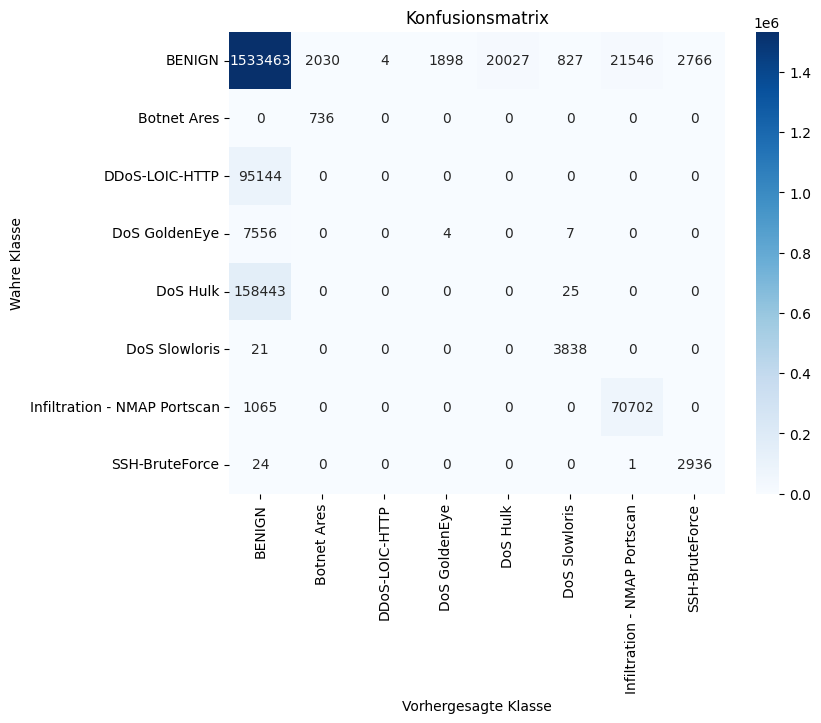

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
